In [75]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import os

In [76]:
Train_dir = 'C:/Users/Hrishikesh M Rao/Documents/archive (1)/ck/CK+48'
emotions_loc = 'C:/Users/Hrishikesh M Rao/Documents/archive (1)/ck/CK+48'

In [77]:
images = []
labels = []
i=0
for emotions in os.listdir(Train_dir):
    emotion_path = os.path.join(emotions_loc,emotions)
    for filename in os.listdir(emotion_path):
        if filename.endswith('.png'):
            image_path = os.path.join(emotion_path, filename)
            image = Image.open(image_path)
            desired_size = (224, 224)
            image = image.resize(desired_size)
            image = np.array(image)
            image = image / 255.0
            images.append(image)
            label = np.zeros(7)
            label[i] = 1
            labels.append(label)
    i+=1       

The shape of the images list is = (981, 224, 224)
The size of the images list is = 49222656
[1. 0. 0. 0. 0. 0. 0.]


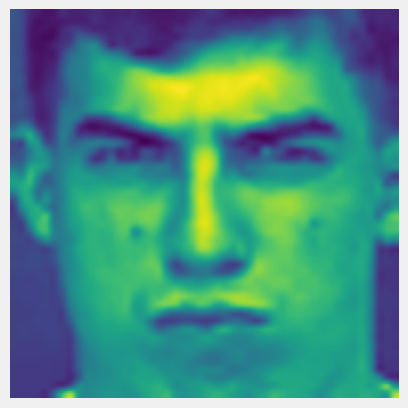

In [78]:
print("The shape of the images list is = "+str(np.shape(images)))
print("The size of the images list is = "+str(np.size(images)))

print(labels[i])
i = 98 
plt.imshow(images[i])
plt.axis('off')  # Hide axis labels and ticks
plt.show()


## Reshape the images and label matrix as necessary

In [79]:

images = np.transpose(images, (1, 2, 0))
images = images.reshape(224*224,981)
labels = np.array(labels)
labels = np.transpose(labels,(1,0))

# Shuffle the dataset
num_samples = images.shape[1]
indices = np.arange(num_samples)
np.random.shuffle(indices)
images = images[:,indices]
labels = labels[:,indices]



[0. 0. 0. 0. 0. 1. 0.]


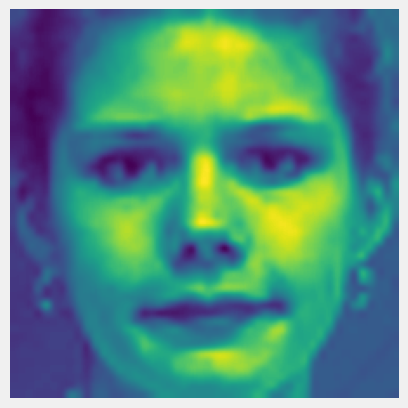

In [80]:
print(labels[:,i])
i = 1  # Change this to the index of the image you want to plot

# Select the column corresponding to the ith image
selected_image = images[:, i]

# Reshape the selected image back to its original shape (224x224)
original_shape_image = selected_image.reshape(224, 224)

plt.imshow(original_shape_image)
plt.axis('off')  # Hide axis labels and ticks
plt.show()

## Normalizer

In [81]:
def Normalise(parameter):

    mean = np.mean(parameter)
    std = np.std(parameter)
    parameter = (parameter-mean)/(std)
    
    return parameter

def MinMax(parameter):
    
    min = np.min(parameter)
    max = np.max(parameter)
    deviation = max - min
    parameter = (parameter-min)/(deviation)
    
    return parameter

In [82]:
images = Normalise(images)
#images = MinMax(images)

images_Df=pd.DataFrame(images)
labels_Df=pd.DataFrame(labels)
images_Df

,0,1,2,3,4,5,6,7,8,9,...,971,972,973,974,975,976,977,978,979,980
0,-1.533135,-0.797428,-0.647562,-1.519511,-0.783804,-0.225212,-1.642129,-1.219779,-0.688435,-0.402326,...,0.415126,-1.655753,-0.892798,0.823852,-0.225212,-1.478639,-1.287900,-0.688435,-1.505887,0.551368
1,-1.533135,-0.797428,-0.647562,-1.519511,-0.783804,-0.225212,-1.655753,-1.233403,-0.688435,-0.402326,...,0.401502,-1.655753,-0.892798,0.837476,-0.238836,-1.478639,-1.287900,-0.702059,-1.505887,0.551368
2,-1.533135,-0.797428,-0.647562,-1.519511,-0.783804,-0.225212,-1.655753,-1.260651,-0.688435,-0.402326,...,0.374253,-1.655753,-0.906422,0.837476,-0.266084,-1.478639,-1.287900,-0.702059,-1.505887,0.564992
3,-1.533135,-0.797428,-0.647562,-1.546760,-0.783804,-0.211588,-1.669377,-1.301524,-0.688435,-0.402326,...,0.347005,-1.655753,-0.933670,0.851100,-0.306957,-1.478639,-1.301524,-0.715683,-1.505887,0.592241
4,-1.533135,-0.783804,-0.661186,-1.560384,-0.783804,-0.197963,-1.710250,-1.369645,-0.674811,-0.402326,...,0.292508,-1.669377,-0.960919,0.864725,-0.361454,-1.478639,-1.301524,-0.729307,-1.505887,0.605865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50171,-1.424142,-0.702059,-0.702059,-0.920046,-0.674811,-0.238836,-0.783804,-1.110785,-1.778371,-0.688435,...,-1.083537,-1.778371,-0.633938,-0.920046,-0.293333,-1.478639,0.660362,-0.334205,-1.424142,-1.083537
50172,-1.424142,-0.702059,-0.688435,-0.933670,-0.674811,-0.266084,-0.770180,-1.124409,-1.778371,-0.688435,...,-0.988167,-1.778371,-0.606689,-0.906422,-0.279709,-1.492263,0.660362,-0.334205,-1.437766,-0.974543
50173,-1.410518,-0.729307,-0.688435,-0.933670,-0.674811,-0.266084,-0.756556,-1.151658,-1.778371,-0.688435,...,-0.933670,-1.778371,-0.593065,-0.920046,-0.279709,-1.505887,0.660362,-0.334205,-1.451390,-0.879174
50174,-1.410518,-0.729307,-0.688435,-0.933670,-0.674811,-0.266084,-0.756556,-1.151658,-1.778371,-0.688435,...,-0.892798,-1.778371,-0.593065,-0.920046,-0.279709,-1.505887,0.660362,-0.334205,-1.451390,-0.824677


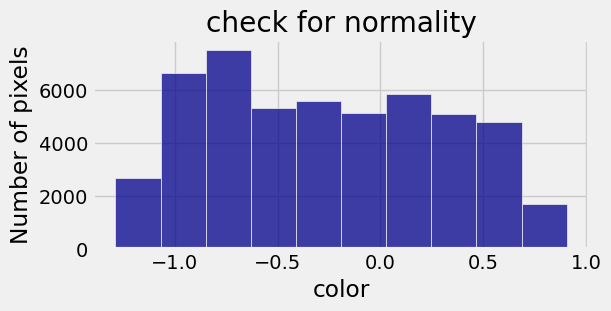

In [83]:

import matplotlib.style as style
style.use('fivethirtyeight')

fig = plt.figure(constrained_layout=True, figsize=(6,3))
sns.histplot(images_Df.loc[:,1], kde=False, color='darkblue', bins=10)
plt.xlabel('color')  # Add a label to the x-axis.
plt.ylabel('Number of pixels')  # Add a label to the y-axis.
plt.title('check for normality')  # Add a title to the plot.

plt.show()


In [84]:
images_Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50176 entries, 0 to 50175
Columns: 981 entries, 0 to 980
dtypes: float64(981)
memory usage: 375.5 MB


In [85]:
images_Df.describe()

,0,1,2,3,4,5,6,7,8,9,...,971,972,973,974,975,976,977,978,979,980
count,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,...,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000
mean,-0.758940,-0.257475,0.435326,-0.375798,-0.085455,0.721619,0.233761,0.440054,0.029169,0.386099,...,-0.055931,-0.252235,-0.448698,0.414477,0.054668,-0.638777,-0.207974,0.440196,-0.655098,0.575831
std,0.559732,0.549573,0.905319,0.847569,0.801322,0.998881,1.103281,1.302667,1.074982,0.923698,...,0.997335,1.011475,0.802717,1.206122,0.705573,0.636913,0.541586,0.922072,0.648773,1.069295
min,-1.778371,-1.287900,-1.737498,-1.778371,-1.751123,-1.778371,-1.778371,-1.696626,-1.778371,-1.683002,...,-1.778371,-1.778371,-1.778371,-1.751123,-1.247027,-1.778371,-1.533135,-1.574008,-1.778371,-1.683002
25%,-1.260651,-0.702059,-0.334205,-1.056288,-0.661186,-0.129842,-0.783804,-1.138033,-0.797428,-0.429575,...,-1.029040,-1.369645,-1.056288,-0.906422,-0.497696,-1.274276,-0.538568,-0.306957,-1.328772,-0.293333
50%,-0.715683,-0.293333,0.633113,-0.375078,-0.143467,1.028215,0.333381,0.987342,-0.020849,0.401502,...,0.142642,0.088145,-0.538568,0.714858,0.047272,-0.538568,-0.116218,0.469623,-0.565817,0.796604
75%,-0.347830,0.210763,1.205330,0.319756,0.537744,1.695801,1.287075,1.695801,0.973718,1.232578,...,0.728483,0.605865,0.197139,1.695801,0.633113,-0.088970,0.183514,1.300699,-0.088970,1.654929
max,0.524120,0.905597,1.695801,1.518686,1.600432,1.695801,1.695801,1.695801,1.695801,1.695801,...,1.695801,1.545935,1.695801,1.695801,1.695801,1.028215,1.069088,1.695801,0.960094,1.695801


## Initialise W and b for every node of each layer

In [86]:
def initialize_parameters(layers): 
    parameters = {}
    L = len(layers)
    for l in range(1, L):
        
        parameters['W' + str(l)] = np.random.randn(layers[l],layers[l-1])
        
        parameters['b' + str(l)] = np.zeros((layers[l],1))
  
    return parameters

## The Activation Fuctions

In [95]:
def sigmoid(Z):
    a = 1/(1+np.exp(-Z))
    return a

def relu(Z):
    a = np.maximum(0,Z)
    return a

def soft_max(Z):
    exp = np.exp(Z-np.max(Z,axis=0))
    a = exp/(np.sum(exp,axis=0,keepdims=True))
    return a

## Propagate forward

In [159]:
def forward_propagation(images,parameters):
    
    cache = {}
    L= int(len(parameters)/2)
    
    cache['Z'+str(1)] = (np.dot(parameters['W'+str(1)],images))+parameters['b'+str(1)]
    cache['A'+str(1)] = relu(cache['Z'+str(1)])
    cache['A'+str(1)] = MinMax(cache['A'+str(1)])
    
    for l in range(2,L):
        cache['Z'+str(l)] = (np.dot(parameters['W'+str(l)],cache['A'+str(l-1)]))+parameters['b'+str(l)]
        cache['A'+str(l)] = relu(cache['Z'+str(l)])
        cache['A'+str(l)] = MinMax(cache['A'+str(l)])
        
    cache['Z'+str(L)] = (np.dot(parameters['W'+str(L)],cache['A'+str(L-1)]))+parameters['b'+str(L)]
    cache['A'+str(L)] = soft_max(cache['Z'+str(L)])
    
    cache['A0'] = images
    A4 = cache['A'+str(L)]

    return A4,cache


## Loss Function

In [160]:
def compute_loss(A4,labels,epsilon):
    
    m = labels.shape[1]
    cost = np.sum(-(np.sum(labels*np.log(A4+epsilon),axis=0,keepdims=False)))/m
    #cost = -np.sum(np.sum(np.multiply(labels, np.log(A4)) + np.multiply((1 - labels), np.log(1 - A4)),axis=1),axis=0)/m
    
    return cost

In [186]:
def backward_propagation(images, labels, cache, parameters,epsilon):
    
    grads={}
    m=images.shape[1]
    L = int(len(cache)/2)
    
    grads['dZ'+str(L)] =  (cache['A'+str(L)]-labels)
    grads['dW'+str(L)] = np.dot(grads['dZ'+str(L)],cache['A'+str(L-1)].T)/m
    grads['db'+str(L)] = np.sum(grads['dZ'+str(L)],axis=1,keepdims=True)/m #sum by the rows of dZ with keepdims=True 
    grads['dA'+str(L-1)] = np.dot(parameters['W'+str(L)].T,grads['dZ'+str(L)])
    
    for l in range(L-1,0,-1):
        grads['dZ'+str(l)] = np.where(cache['Z'+str(l)]>0,1,0)*grads['dA'+str(l)]
        grads['dA'+str(l-1)] = np.dot(parameters['W'+str(l)].T,grads['dZ'+str(l)])
        grads['dW'+str(l)] = np.dot(grads['dZ'+str(l)],cache['A'+str(l-1)].T)/m
        grads['db'+str(l)] = np.sum(grads['dZ'+str(l)],axis=1,keepdims=True)/m #sum by the rows of dZ with keepdims=True
    
    return grads

## Update Parameters

In [187]:
def update_parameters(parameters, grads, learning_rate):
    
    L = int(len(parameters)/2)
    for l in range(L):
        
        parameters['W'+str(l+1)]= (parameters['W'+str(l+1)])-(learning_rate*grads['dW'+str(l+1)])

        parameters['b'+str(l+1)]= (parameters['b'+str(l+1)])-(learning_rate*grads['db'+str(l+1)])
        
    return parameters

In [188]:
def calculate_accuracy(true_labels, A4):
    
    # Ensure that the input arrays have the same shape
    assert true_labels.shape == A4.shape, "Input shapes do not match"
 
    # Calculate the number of correct predictions
    mask1 = (np.abs(true_labels-A4)<=0.25)
    mask2 = (np.all(mask1,axis=0))
    tl_Df = pd.DataFrame(true_labels)
    print(tl_Df)
    A4_Df = pd.DataFrame(A4)
    print(A4_Df)
    # Count the total number of times 1 appears using the mask
    num_correct = np.sum(mask2)
    
    # Calculate the total number of samples
    total_samples = true_labels.shape[1]

    # Calculate accuracy
    accuracy = (num_correct*100) / total_samples
    
    return accuracy

## Combine all the functions to create a working model

In [189]:
def predictor(images, labels, learning_rate, num_iterations=15000, print_cost = True, epsilon = 1e-15):
    grads = {}
    costs = []
    layers = [images.shape[0],5,5,labels.shape[0]]
    # Initialse w and b
    parameters=initialize_parameters(layers)
    
    for i in range(0, num_iterations):
        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        A4, cache = forward_propagation(images, parameters)
        
        # Loss
        cost = compute_loss(A4, labels, epsilon)

        # Backward propagation.
        grads = backward_propagation(images, labels, cache, parameters,epsilon)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            costs.append(cost)
            accuracy = calculate_accuracy(labels, A4)
            print("Accuracy:", accuracy, "%")  
                 
        # plot the loss
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters 

In [190]:
predictor(images, labels, learning_rate = 0.01)




Cost after iteration 0: 2.1706938825264617
   0    1    2    3    4    5    6    7    8    9    ...  971  972  973  974  \
0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  ...  0.0  1.0  0.0  0.0   
5  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  1.0  0.0  1.0  1.0   

   975  976  977  978  979  980  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  1.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  
5  0.0  0.0  1.0  0.0  0.0  1.0  
6  0.0  1.0  0.0  1.0  1.0  0.0  

[7 rows x 981 columns]
        0         1 

KeyboardInterrupt: 